# Weight Normalization

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

import time
import cPickle as pickle
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Model baseline

In [2]:
batch_size = 32
global_step = 0
save_path = 'models/norm.ckpt'
xlen = 28*28
ylen = 10

train_steps = 150000
info_every = 250
test_every = 1000

## Build model

In [3]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

x = tf.placeholder(tf.float32, shape=[None, xlen], name="x")
y_ = tf.placeholder(tf.float32, shape=[None, ylen], name="y_")
init = tf.truncated_normal_initializer(mean=0., stddev=.075, seed=1234, dtype=tf.float32)

W_hat = tf.get_variable("W", shape=[xlen,ylen], initializer=init)
W = tf.nn.l2_normalize(W_hat, [0,1])

output = tf.nn.softmax(tf.matmul(x, W))
sess.run(tf.initialize_all_variables())

In [4]:
loss = tf.nn.l2_loss( y_ - output ) / (ylen*batch_size)

optimizer = tf.train.AdamOptimizer(1e-4)
grads = optimizer.compute_gradients(loss, var_list=tf.trainable_variables())
train_op = optimizer.apply_gradients(grads)

sess.run(tf.initialize_all_variables())

## Model overview

In [5]:
total_parameters = 0 ; print "Model overview:"
for variable in tf.trainable_variables():
    shape = variable.get_shape()
    variable_parameters = 1
    for dim in shape:
        variable_parameters *= dim.value
    print '\tvariable "{}" has {} parameters' \
        .format(variable.name, variable_parameters)
    total_parameters += variable_parameters
print "Total of {} parameters".format(total_parameters)

Model overview:
	variable "W:0" has 7840 parameters
Total of 7840 parameters


## Train

In [6]:
correct_prediction = tf.equal(tf.argmax(output,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [7]:
loss_curve = np.zeros((train_steps/info_every, 2))
acc_curve = np.zeros((train_steps/test_every, 2))

begin = time.time()
for i in range(train_steps):
    batch_start = time.time()
    
    batch = mnist.train.next_batch(batch_size)
    feed = {x: batch[0], y_: batch[1]}
    train_loss, _ = sess.run([loss, train_op], feed_dict=feed)
    
    if i%test_every == 0:
        feed = {x: mnist.test.images, y_: mnist.test.labels}
        acc = accuracy.eval(feed_dict=feed)
        acc_curve[i/test_every,:] = [i, acc]
        print "{}/{}: test accuracy: {:3f}".format(i, train_steps, acc)
    if i%info_every == 0:
        loss_curve[i/info_every,:] = [i, train_loss]
        print "\tstep {}, loss {:3f}, batch time {:3f}".format(i, train_loss, time.time()-batch_start)
print "\ntotal runtime: {:3f} seconds".format(time.time()-begin)

0/150000: test accuracy: 0.085100
	step 0, loss 0.045132, batch time 0.050696
	step 250, loss 0.043271, batch time 0.001400
	step 500, loss 0.041231, batch time 0.001632
	step 750, loss 0.040067, batch time 0.001046
1000/150000: test accuracy: 0.704500
	step 1000, loss 0.036882, batch time 0.034970
	step 1250, loss 0.035946, batch time 0.001868
	step 1500, loss 0.032686, batch time 0.001029
	step 1750, loss 0.033453, batch time 0.001123
2000/150000: test accuracy: 0.712300
	step 2000, loss 0.032110, batch time 0.034258
	step 2250, loss 0.029686, batch time 0.001255
	step 2500, loss 0.033984, batch time 0.001347
	step 2750, loss 0.035704, batch time 0.001145
3000/150000: test accuracy: 0.716000
	step 3000, loss 0.032295, batch time 0.036345
	step 3250, loss 0.031150, batch time 0.001490
	step 3500, loss 0.034323, batch time 0.001957
	step 3750, loss 0.033725, batch time 0.001129
4000/150000: test accuracy: 0.725900
	step 4000, loss 0.028588, batch time 0.036071
	step 4250, loss 0.034541

In [8]:
feed = {x: mnist.test.images, y_: mnist.test.labels}
acc = accuracy.eval(feed_dict=feed)
print "final test accuracy: {:3f}".format(acc)

final test accuracy: 0.711300


## Plot performance

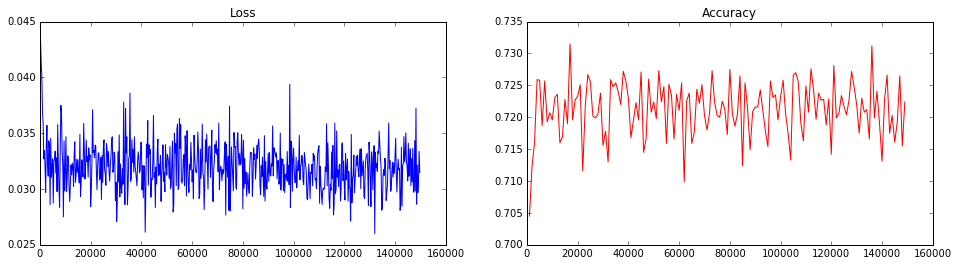

In [9]:
plt.figure(0, figsize=(16,4))
plt.subplot(121)
plt.title("Loss")
plt.plot(loss_curve[1:,0], loss_curve[1:,1], 'b-')
plt.subplot(122)
plt.title("Accuracy")
plt.plot(acc_curve[1:,0], acc_curve[1:,1], 'r-')

with open('norm.p', 'w') as f:
    pickle.dump(acc_curve, f)

## Plot weights

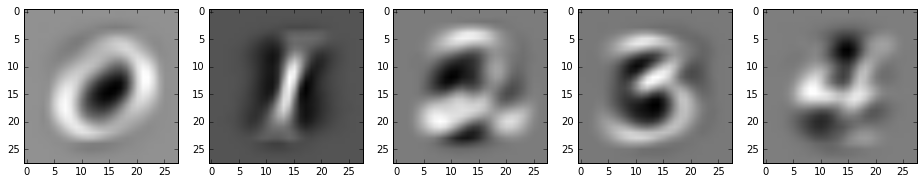

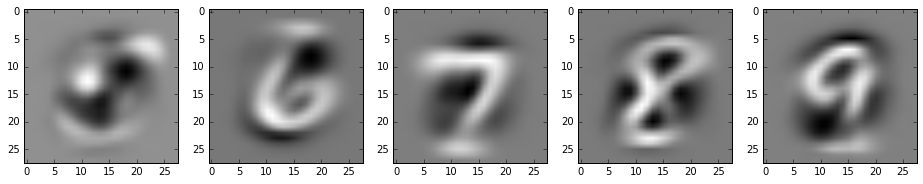

In [10]:
W_ = W.eval()
for i in range(0,10,5):
    img1 = np.reshape(W_[:,i], (28,28))
    img2 = np.reshape(W_[:,i+1], (28,28))
    img3 = np.reshape(W_[:,i+2], (28,28))
    img4 = np.reshape(W_[:,i+3], (28,28))
    img5 = np.reshape(W_[:,i+4], (28,28))
    plt.figure(i, figsize=(16,4))
    plt.subplot(151)
    plt.imshow(img1, cmap=cm.gray)
    plt.subplot(152)
    plt.imshow(img2, cmap=cm.gray)
    plt.subplot(153)
    plt.imshow(img3, cmap=cm.gray)
    plt.subplot(154)
    plt.imshow(img4, cmap=cm.gray)
    plt.subplot(155)
    plt.imshow(img5, cmap=cm.gray)

In [13]:
print np.min(W_), np.max(W_), "\n", W_

-0.0514058 0.0789484 
[[  2.46458083e-32  -2.23546905e-32  -2.86864739e-33 ...,  -8.83448841e-34
   -2.34153347e-32   2.24722488e-32]
 [  4.44083252e-33   2.14384750e-32  -1.71487552e-32 ...,  -1.66022943e-32
   -1.02356832e-32   1.90328184e-32]
 [ -2.46484370e-32  -1.11372433e-32   7.20861625e-33 ...,   4.52281884e-33
    2.08301537e-32   1.24956210e-32]
 ..., 
 [ -1.27719445e-32   6.94508144e-33   2.40351875e-32 ...,  -8.11394820e-33
    1.40546821e-32   1.21660190e-32]
 [ -9.14968950e-33   2.03163848e-32   7.60745561e-33 ...,  -1.81759859e-32
    3.17632275e-33   1.78055773e-32]
 [  7.50338395e-33   1.96359958e-33  -8.23897470e-34 ...,  -2.26725897e-32
   -1.12231998e-32   3.01794973e-34]]


## Saver IO

In [11]:
# saver = tf.train.Saver(tf.all_variables())
# load_was_success = True # yes, I'm being optimistic
# try:
#     save_dir = '/'.join(save_path.split('/')[:-1])
#     ckpt = tf.train.get_checkpoint_state(save_dir)
#     load_path = ckpt.model_checkpoint_path
#     saver.restore(sess, load_path)
# except:
#     print "no saved model to load. starting new session"
#     load_was_success = False
# else:
#     print "loaded model: {}".format(load_path)
#     saver = tf.train.Saver(tf.all_variables())
#     global_step = int(load_path.split('-')[-1])

In [12]:
# #fc 1 layer
# W1 = tf.get_variable("W1", shape=[xlen,ylen], initializer=init)
# b1 = tf.get_variable("b1", shape=[ylen], initializer=init)
# output = tf.nn.softmax(tf.matmul(x, W1) + b1)